# 多输入多输出通道

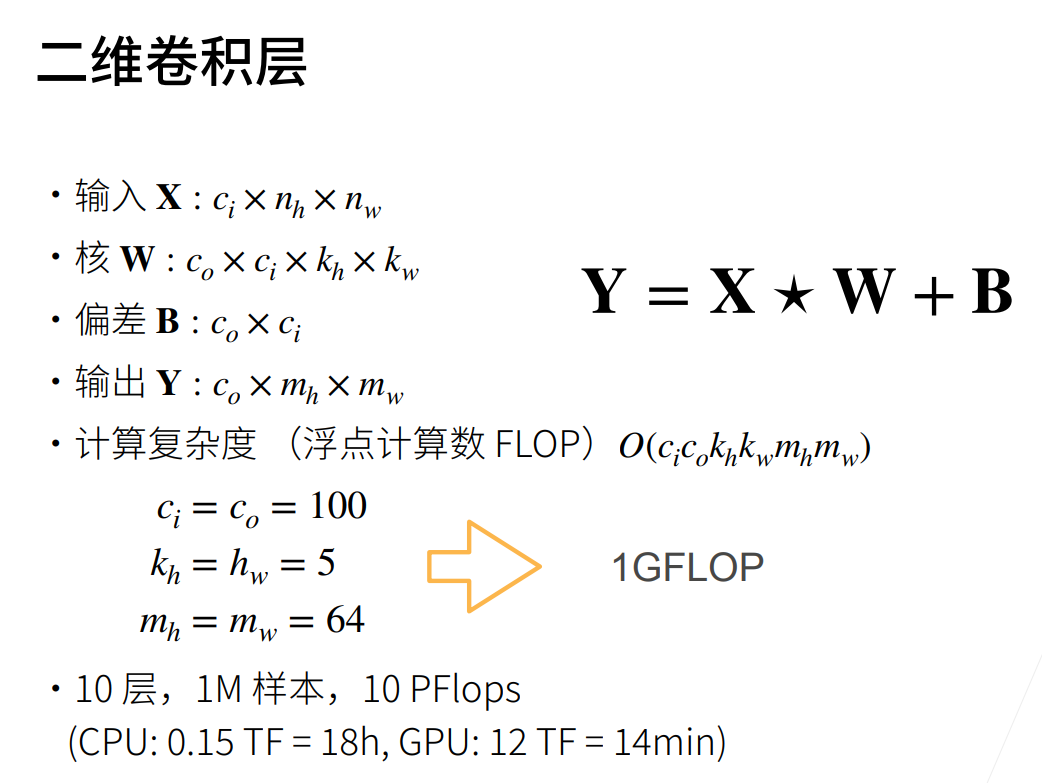

## 实现多输入通道互相关运算

In [1]:
import torch
from d2l import torch as d2l

#实现多输入通道互相关运算
#我们所做的就是对每个通道执行互相关操作，然后将结果相加。
#x是输入，k是卷积核
#zip作用这样可以对输入通道的维数做遍历
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

#验证，和幻灯片是一一对应的
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 实现多输出通道互相关运算

In [2]:
#实现多输出通道互相关运算
#x是3D，K是4D,最外面那个维度是输出通道
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度(最外面的那个维度），每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起,在0这个维度上stack
    #小k是3D的tensor
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

#构造一个3个通道的卷积核，通过每个元素+1构造这个卷积核
K = torch.stack((K, K + 1, K + 2), 0)
#卷积核是个4D的tensor
K.shape

torch.Size([3, 2, 2, 2])

In [3]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1*1卷积

In [4]:
#用全连接实现一个多输入多输出的互相关操作
#x是输入
#1*1的卷积等价于一个全连接层
def corr2d_multi_in_out_1x1(X, K):
    #输入通道，高，宽
    c_i, h, w = X.shape
    #输出通道
    c_o = K.shape[0]
    #把x展平
    X = X.reshape((c_i, h * w))
    #把最后两个维度拿掉
    #这样X和K都是一个矩阵
    K = K.reshape((c_o, c_i))
    #直接调用一个矩阵乘法
    Y = torch.matmul(K, X)
    #输出是一个3D的tensor
    return Y.reshape((c_o, h, w))

#均值为0，方差为1的正太分布初始化
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
#Y1=Y2 几乎认为是完全一样
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 答疑

+ 通常输入输出的高宽减半的话，通道数会加倍，相当于把信息在空间上压缩了之后，会用更多的通道来存储起来。
+ 性能分为计算性能和模型性能。padding太多不太会影响模型精度，但是太多的话，模型复杂度会提高。
+ 不同通道的卷积核大小是一样的，这样方便计算。同一通道的卷积核是不一样的。
+ bias不会有特别大的作用，但是有作用，而且很少，不会对计算产生什么影响，一般都是用的。
+ 卷积核的参数是学出来的，不是写出来的。
+ 三维卷积：输入是4D的张量，卷积核是5D的张量，输出是4D的张量。
+ mobilenet不像之前把输入通道做3*3的卷积，然后再加起来做输出通道，而是直接用3*3的卷积对输入通道做卷积，然后再对每一个做通道融合，这样计算量小。
+ 卷积对位置非常敏感，输出的元素（i，j)是输入（i，j)附件那些元素的信息
+ 不同通道之间卷积核是不共享参数的。
+ 输入通道是确定的，不能动态变化
+ RNN是什么，对RGB做二维，然后再concat
+ VScode